In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv("diamonds.csv", index_col = 0)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
data.shape

(53940, 10)

In [4]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [5]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [6]:
data['cut'].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [7]:
data['color'].value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [8]:
data['clarity'].value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

In [9]:
# encode the values to categorical variables in cut
cut_map = {'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}
data['cut'] = data['cut'].map(cut_map)

# encode the values to categorical varibales in color
color_map = {'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}
data['color'] = data['color'].map(color_map)

# encode the values to categorical variables in clarity
clarity_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
data['clarity'] = data['clarity'].map(clarity_map)

In [10]:
data = data.drop(data[data['x']==0].index)
data = data.drop(data[data['y']==0].index)
data = data.drop(data[data['z']==0].index)

In [11]:
# dealing with outliers
data = data[data['depth'] < data['depth'].quantile(0.99)]
data = data[data['table'] < data['table'].quantile(0.99)]
data = data[data['x'] < data['x'].quantile(0.99)]
data = data[data['y'] < data['y'].quantile(0.99)]
data = data[data['z'] < data['z'].quantile(0.99)]

In [12]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
2,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
4,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
5,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75
6,0.24,2,0,5,62.8,57.0,336,3.94,3.96,2.48


In [13]:
data.shape

(51130, 10)

In [14]:
53940 - 51130

2810

In [15]:
data.corr()

,carat,cut,color,clarity,depth,table,price,x,y,z
carat,1.000000,-0.120075,-0.240616,-0.317281,0.007683,0.189037,0.909757,0.984033,0.983335,0.982462
cut,-0.120075,1.000000,0.010195,0.171938,-0.183709,-0.410072,-0.045488,-0.109739,-0.112521,-0.132260
color,-0.240616,0.010195,1.000000,-0.051846,-0.043652,-0.018744,-0.107225,-0.223167,-0.223164,-0.227537
clarity,-0.317281,0.171938,-0.051846,1.000000,-0.046141,-0.159224,-0.085324,-0.339735,-0.334478,-0.341368
depth,0.007683,-0.183709,-0.043652,-0.046141,1.000000,-0.296705,-0.014495,-0.042004,-0.043236,0.073396
table,0.189037,-0.410072,-0.018744,-0.159224,-0.296705,1.000000,0.128550,0.194649,0.189486,0.157847
price,0.909757,-0.045488,-0.107225,-0.085324,-0.014495,0.128550,1.000000,0.873697,0.875078,0.870510
x,0.984033,-0.109739,-0.223167,-0.339735,-0.042004,0.194649,0.873697,1.000000,0.998597,0.991793
y,0.983335,-0.112521,-0.223164,-0.334478,-0.043236,0.189486,0.875078,0.998597,1.000000,0.991680
z,0.982462,-0.132260,-0.227537,-0.341368,0.073396,0.157847,0.870510,0.991793,0.991680,1.000000


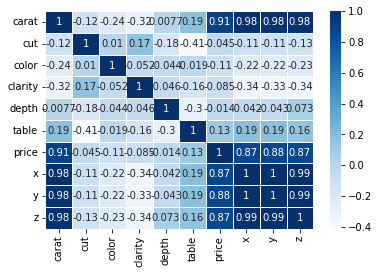

In [16]:
sns.heatmap(data.corr(), annot = True, linewidth = 0.5, cmap = 'Blues')
plt.show()

In [17]:
model_data = data.copy()

X = model_data.drop(['price'], axis = 1)
y = model_data['price']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In [21]:
xgb1 = XGBRegressor()

parameters = {
                'objective':['reg:squarederror'],
                'learning_rate': [0.001, 0.01, 0.1],
                'max_depth': [3, 5, 7, 9],
                'min_child_weight': [3, 5, 7],
                'subsample': [0.1, 0.5, 1.0],
                'colsample_bytree': [0.1, 0.5, 1.0]}

xgb_grid = GridSearchCV(xgb1,
                       parameters,
                       cv = 3,
                       n_jobs = -1,
                       verbose = 0)

xgb_grid.fit(X_train, y_train)

xgb_cv = (xgb_grid.best_estimator_)

eval_set = [(X_train, y_train),
           (X_val, y_val)]

model = xgb_cv.fit(X_train,
                   y_train,
                   eval_set = eval_set,
                   eval_metric = 'mae',
                   early_stopping_rounds = 50,
                   verbose = False)

/Users/anuragkotiyal/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/anuragkotiyal/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [22]:
print("MAE:", mean_absolute_error(y_val, model.predict(X_val)))
print("MSE:", mean_squared_error(y_val, model.predict(X_val)))
print("R2:", r2_score(y_val, model.predict(X_val)))

MAE: 235.81744111402614
MSE: 202079.94953581336
R2: 0.9830441282600116


In [23]:
model.save_model('xgb_model.json')